<a href="https://colab.research.google.com/github/neelimareddyb/Skin-Disease-Classification/blob/main/ACV_case_study_Week_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1: Setup Kaggle Configuration
import os
from google.colab import files

print("Please upload your kaggle.json file.")
# This prompts you to upload the file
files.upload()

# Move it to the correct location for the API to find it
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured successfully!")

Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
Kaggle API configured successfully!


In [ ]:
# CELL 2: Download HAM10000
# We use the dataset handle: kmader/skin-cancer-mnist-ham10000
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

print("Dataset downloaded.")

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [01:33<00:00, 64.8MB/s]
100% 5.20G/5.20G [01:33<00:00, 59.8MB/s]
Dataset downloaded.


In [ ]:
# CELL 3: Unzip the data
import zipfile

print("Extracting files... this may take a few seconds.")

# Unzip into a folder named 'ham10000_data' to keep things clean
with zipfile.ZipFile("skin-cancer-mnist-ham10000.zip", 'r') as zip_ref:
    zip_ref.extractall("ham10000_data")

print("Extraction complete.")

Extracting files... this may take a few seconds.
Extraction complete.


In [ ]:
# CELL 4: Map Image IDs to File Paths
import pandas as pd
import os
from glob import glob

base_dir = 'ham10000_data'

# 1. Locate all .jpg image files in the extracted folder
# The wildcards (*) find files in subfolders (part_1 and part_2)
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

# 2. Load the metadata (the 'answers' key)
metadata = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))

# 3. Add a 'path' column to the metadata so we know where each image lives
metadata['path'] = metadata['image_id'].map(image_path_dict)

# 4. Drop any rows where the image might be missing (sanity check)
metadata.dropna(inplace=True)

print(f"Successfully mapped {len(metadata)} images.")
metadata.head()

Successfully mapped 9958 images.


,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ham10000_data/ham10000_images_part_1/ISIC_0027...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ham10000_data/ham10000_images_part_1/ISIC_0025...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ham10000_data/ham10000_images_part_1/ISIC_0026...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ham10000_data/ham10000_images_part_1/ISIC_0025...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ham10000_data/ham10000_images_part_2/ISIC_0031...


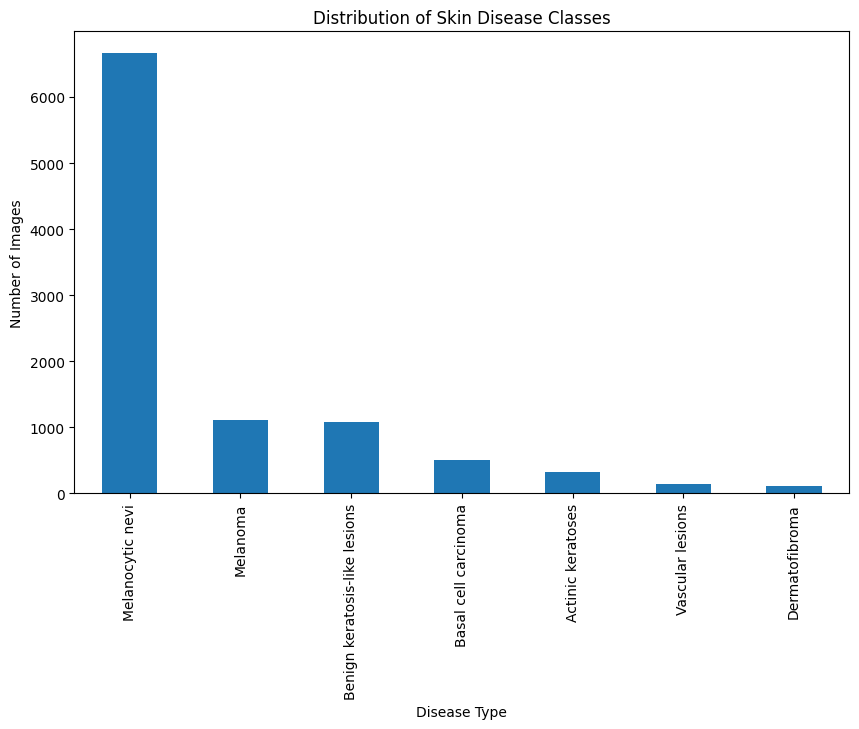


Exact Counts:
cell_type
Melanocytic nevi                 6660
Melanoma                         1111
Benign keratosis-like lesions    1089
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64


In [ ]:
# CELL 5: Class Distribution Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionary to make disease codes readable
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Add readable names to the dataframe
metadata['cell_type'] = metadata['dx'].map(lesion_type_dict)

# Plot the counts
plt.figure(figsize=(10, 6))
metadata['cell_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Skin Disease Classes')
plt.ylabel('Number of Images')
plt.xlabel('Disease Type')
plt.show()

print("\nExact Counts:")
print(metadata['cell_type'].value_counts())

In [ ]:
# CELL 6: Stratified Train-Test Split
from sklearn.model_selection import train_test_split

# 1. First split: 80% Train, 20% Temp (Test + Val)
df_train, df_temp = train_test_split(
    metadata,
    test_size=0.2,
    stratify=metadata['dx'], # Keep class ratios same
    random_state=42
)

# 2. Second split: Split the 20% Temp into 10% Val and 10% Test
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp['dx'],
    random_state=42
)

print(f"Training Set: {len(df_train)} images")
print(f"Validation Set: {len(df_val)} images")
print(f"Test Set: {len(df_test)} images")

# Reset indices for cleanliness
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Training Set: 7966 images
Validation Set: 996 images
Test Set: 996 images


In [ ]:
# CELL 7: Custom Dataset Class
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        # Create a mapping from label name (e.g., 'nv') to number (0)
        self.label_map = {
            'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3,
            'akiec': 4, 'vasc': 5, 'df': 6
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 1. Get the image path
        img_path = self.dataframe.iloc[idx]['path']

        # 2. Load Image
        image = Image.open(img_path).convert("RGB")

        # 3. Get Label
        label_str = self.dataframe.iloc[idx]['dx']
        label = self.label_map[label_str]

        # 4. Apply Transforms (Resize, Normalize)
        if self.transform:
            image = self.transform(image)

        return image, label

# Define standard transforms (Resize to 224x224 for ResNet)
# We also normalize using standard ImageNet stats
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # mild augmentation
    transforms.RandomRotation(10),     # mild augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Dataset class defined.")

Dataset class defined.


In [ ]:
# CELL 8: Data Loaders
# Hyperparameters
BATCH_SIZE = 32

# Create Dataset Objects
train_dataset = SkinLesionDataset(df_train, transform=train_transforms)
val_dataset = SkinLesionDataset(df_val, transform=test_transforms)
test_dataset = SkinLesionDataset(df_test, transform=test_transforms)

# Create Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data Loaders ready. Batch size: {BATCH_SIZE}")

Data Loaders ready. Batch size: 32


In [ ]:
# CELL 9: Model Setup
import torchvision.models as models
import torch.nn as nn

# 1. Download pre-trained ResNet18
model = models.resnet18(pretrained=True)

# 2. Freeze early layers (Optional, but speeds up training)
# For this case study, we will fine-tune the whole thing for better accuracy,
# so we WON'T freeze layers.

# 3. Modify the final layer
# ResNet18's last layer is called 'fc' (Fully Connected)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7) # 7 classes for 7 skin diseases

# 4. Move to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model initialized and moved to {device}.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


Model initialized and moved to cuda.


In [ ]:
# CELL 10: Training Loop
import torch.optim as optim
from tqdm import tqdm # Progress bar

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Function
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar
    loop = tqdm(loader, leave=True)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        loop.set_description(f"Loss: {loss.item():.4f}")

    return running_loss / len(loader), 100 * correct / total

# Run for 5 Epochs (You can increase this later)
EPOCHS = 5
print(f"Starting training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS} -> Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

print("Training Complete!")

Starting training for 5 epochs...


Loss: 0.7463: 100%|██████████| 249/249 [01:42<00:00,  2.42it/s]


Epoch 1/5 -> Loss: 0.6846, Accuracy: 76.55%


Loss: 0.3020: 100%|██████████| 249/249 [01:37<00:00,  2.57it/s]


Epoch 2/5 -> Loss: 0.4304, Accuracy: 84.26%


Loss: 0.3517: 100%|██████████| 249/249 [01:34<00:00,  2.63it/s]


Epoch 3/5 -> Loss: 0.3441, Accuracy: 87.72%


Loss: 0.2998: 100%|██████████| 249/249 [01:35<00:00,  2.62it/s]


Epoch 4/5 -> Loss: 0.2650, Accuracy: 90.66%


Loss: 0.1331: 100%|██████████| 249/249 [01:36<00:00,  2.59it/s]

Epoch 5/5 -> Loss: 0.2068, Accuracy: 92.53%
Training Complete!


In [ ]:
# CELL 11: Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Switch to Evaluation Mode
model.eval()

all_preds = []
all_labels = []

print("Evaluating on Test Set...")

# 2. No gradient needed for evaluation (saves memory)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predictions (max probability)
        _, preds = torch.max(outputs, 1)

        # Store results
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Generate the Report
# We map the numbers back to names for readability
target_names = list(test_dataset.label_map.keys())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

Evaluating on Test Set...

Classification Report:
              precision    recall  f1-score   support

          nv       0.91      0.95      0.93       666
         mel       0.81      0.50      0.62       111
         bkl       0.73      0.81      0.77       109
         bcc       0.76      0.65      0.70        52
       akiec       0.64      0.70      0.67        33
        vasc       0.86      0.86      0.86        14
          df       0.50      0.55      0.52        11

    accuracy                           0.86       996
   macro avg       0.74      0.72      0.72       996
weighted avg       0.86      0.86      0.85       996



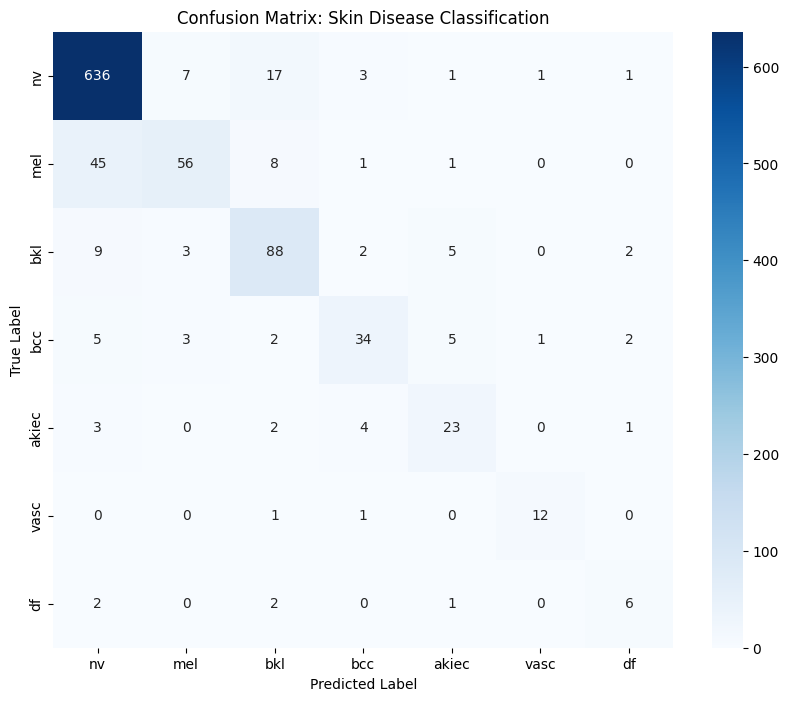

In [ ]:
# CELL 12: Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Skin Disease Classification')
plt.show()

Total Misclassified Images: 141


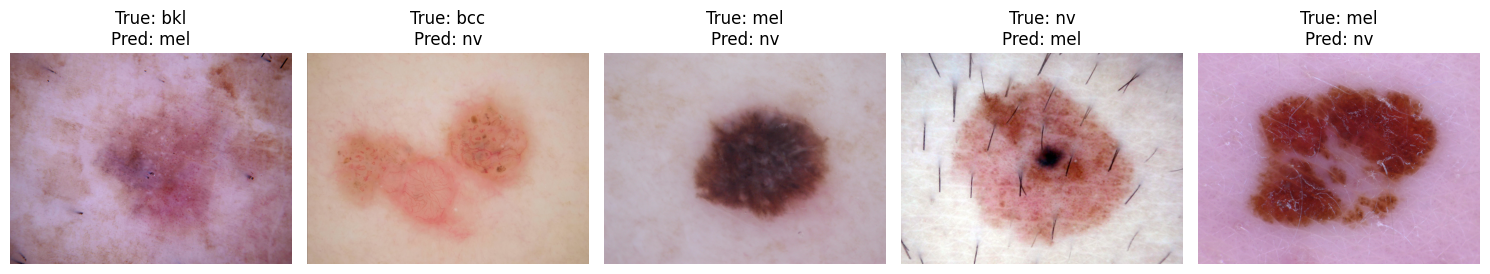

In [ ]:
# CELL 13: Visualize Failure Cases
# Let's find 5 examples where the model was wrong
wrong_indices = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p != l]

print(f"Total Misclassified Images: {len(wrong_indices)}")

# Show the first 5 errors
plt.figure(figsize=(15, 5))
for i, idx in enumerate(wrong_indices[:5]):
    # Get the image path from the dataset
    img_path = test_dataset.dataframe.iloc[idx]['path']
    image = Image.open(img_path)

    true_name = list(test_dataset.label_map.keys())[list(test_dataset.label_map.values()).index(all_labels[idx])]
    pred_name = list(test_dataset.label_map.keys())[list(test_dataset.label_map.values()).index(all_preds[idx])]

    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(f"True: {true_name}\nPred: {pred_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# CELL 14: Brightness Sensitivity Test
from torchvision.transforms import functional as F

# 1. Define a specific "Dark" transform
# We use a lambda function to force a specific brightness reduction (0.5x)
# This is different from RandomColorJitter because it's deterministic (same for all images)
dark_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: F.adjust_brightness(x, 0.5)), # Make it 50% darker
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Create a new Dataset and Loader with this transform
dark_test_dataset = SkinLesionDataset(df_test, transform=dark_test_transforms)
dark_loader = DataLoader(dark_test_dataset, batch_size=32, shuffle=False)

# 3. Evaluate the Model on Dark Images
print("Running evaluation on Low-Light (Dark) images...")

model.eval()
dark_correct = 0
dark_total = 0

with torch.no_grad():
    for images, labels in dark_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        dark_total += labels.size(0)
        dark_correct += (predicted == labels).sum().item()

dark_acc = 100 * dark_correct / dark_total
print(f"Accuracy on Original Test Set: {train_acc:.2f}% (approx from last epoch)")
# Note: Compare this to the number from Cell 11 output
print(f"Accuracy on Dark Test Set: {dark_acc:.2f}%")

drop = train_acc - dark_acc
print(f"\nPerformance Drop: {drop:.2f}%")

Running evaluation on Low-Light (Dark) images...
Accuracy on Original Test Set: 92.53% (approx from last epoch)
Accuracy on Dark Test Set: 68.57%

Performance Drop: 23.96%


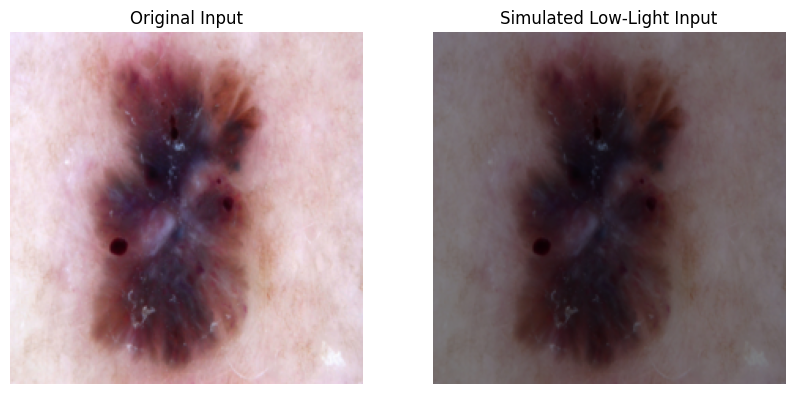

In [ ]:
# CELL 15: Visualize Normal vs Dark
# Get one batch of data
normal_img, _ = test_dataset[0] # Get raw image (tensor)
dark_img, _ = dark_test_dataset[0]

# Helper to un-normalize and display
def show_tensor(tensor, title):
    img = tensor.permute(1, 2, 0).numpy()
    # Undo normalization for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
show_tensor(normal_img, "Original Input")

plt.subplot(1, 2, 2)
show_tensor(dark_img, "Simulated Low-Light Input")
plt.show()

In [ ]:
# CELL 16: Skin Tone Analysis (Proxy Method)
import cv2
import numpy as np

# 1. Function to estimate skin tone intensity
def estimate_skin_tone(image_path):
    # Load image
    img = cv2.imread(image_path)
    if img is None: return 0
    # Convert to HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # The 'Value' channel represents brightness/lightness
    # We take the median to be robust against lesions (which are dark)
    return np.median(hsv[:, :, 2])

# 2. Analyze the Test Set
print("Analyzing skin tones in Test Set...")
tone_values = []
predictions = []
true_labels = []

model.eval()
with torch.no_grad():
    for i in range(len(test_dataset)):
        # Get path and label
        path = test_dataset.dataframe.iloc[i]['path']
        label = test_dataset.dataframe.iloc[i]['dx']
        target = test_dataset.label_map[label]

        # Estimate tone
        tone = estimate_skin_tone(path)
        tone_values.append(tone)

        # Get prediction
        img, _ = test_dataset[i] # Get tensor
        img = img.unsqueeze(0).to(device) # Add batch dim
        out = model(img)
        _, pred = torch.max(out, 1)

        predictions.append(pred.item())
        true_labels.append(target)

# 3. Split into "Light" vs "Dark" groups based on median intensity
median_tone = np.median(tone_values)
print(f"Median Skin Tone Intensity: {median_tone:.2f}")

light_skin_indices = [i for i, t in enumerate(tone_values) if t >= median_tone]
dark_skin_indices = [i for i, t in enumerate(tone_values) if t < median_tone]

# 4. Calculate Accuracy for each group
def calculate_accuracy(indices, preds, trues):
    correct = sum(1 for i in indices if preds[i] == trues[i])
    return 100 * correct / len(indices) if len(indices) > 0 else 0

light_acc = calculate_accuracy(light_skin_indices, predictions, true_labels)
dark_acc = calculate_accuracy(dark_skin_indices, predictions, true_labels)

print(f"Accuracy on Lighter Skin tones: {light_acc:.2f}%")
print(f"Accuracy on Darker Skin tones: {dark_acc:.2f}%")
print(f"Disparity (Bias): {light_acc - dark_acc:.2f}%")

Analyzing skin tones in Test Set...
Median Skin Tone Intensity: 206.00
Accuracy on Lighter Skin tones: 90.50%
Accuracy on Darker Skin tones: 81.06%
Disparity (Bias): 9.44%


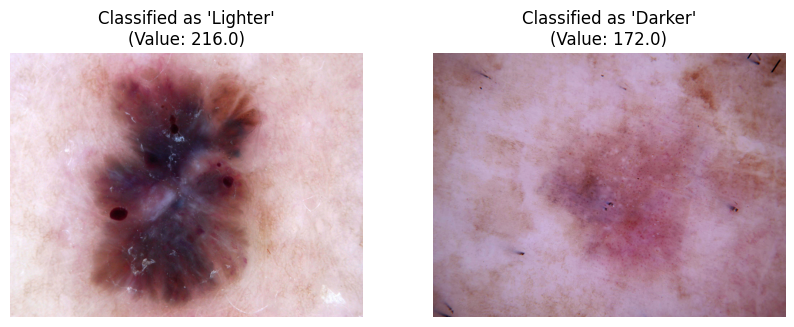

In [ ]:
# CELL 17: Visualize Skin Tone Groups
# Find an example of each
light_idx = light_skin_indices[0]
dark_idx = dark_skin_indices[0]

# Display
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
img_light = Image.open(test_dataset.dataframe.iloc[light_idx]['path'])
plt.imshow(img_light)
plt.title(f"Classified as 'Lighter'\n(Value: {tone_values[light_idx]:.1f})")
plt.axis('off')

plt.subplot(1, 2, 2)
img_dark = Image.open(test_dataset.dataframe.iloc[dark_idx]['path'])
plt.imshow(img_dark)
plt.title(f"Classified as 'Darker'\n(Value: {tone_values[dark_idx]:.1f})")
plt.axis('off')

plt.show()